# Stochastic Gradient Descent

**Prepared by:** [Shashank Ramesh](https://shashankramesh.github.io/index.html) (sramesh@nd.edu, 2023)

## Introduction 


In most engineering fields, optimization problems with objectives that have high computation costs are often encountered. For example, the computation cost of the objective function of a classification problem grows exponentially as the number of classes and size of the data sets grows. In order to speed up computations in these cases, algorithms that reduce the number or complexity of objective function evaluations are needed. Stochastic gradient descent (SGD) is one such algorithm that uses a stochastic approximation of the gradient of the objective function to reduce the computational complexity involved in objective function evaluations.

The SGD algorithm is most commonly used in statistics and machine learning for data classification or regression. For example, SGD along with the backpropagation technique is used to tune the parameters of a neural network [1]. SGD is also used to solve support vector regression problems in [2] and logistic regression in [3].

This notebook presents the theory behind SGD, along with a basic implementation used to solve two classes of problems: regression and classification. The notebook follows the concepts and implementation techniques presented in [4].

### Formulation (Wei Wu, 2011)
Consider the problem of fitting a data set, given by $(x_i, y_i), i=1,2,..,t$, to a given function $y = f_\theta(x)$ which has $\theta$ as parameters. Typically, this problem is formulated as an optimization problem:
$$
\begin{equation}
\theta_t^* = \arg \underset{\theta}{\min} \frac 1 t \sum_{i=1}^{t} \left(L(f_{\theta}(x_i), y_i) + R(\theta)\right)
\end{equation}
$$
where $t$ is the number of data points, $\theta_t^*$ is the parameter that minimize the empirical cost, $(x_i, y_i)$ are the $i^{th}$ training example, $L(s, y)$ is a loss function which gives small value if $s$ is a good prediction for $y$, and $R(\theta)$ is a regularization function for $\theta$  which typically gives small value for small $\theta$. 

For stochastic gradient descent (SGD) method, let $d=(x, y)$ be one data sample, $l(\theta, d) = L(f_{\theta}(x), y) + R(\theta)$ be the cost of $\theta$ for $d$, $g(\theta, d) = \frac{\partial l(\theta, d)}{\partial \theta}$ be the gradient function, and $D_t = (d_1, \cdots, d_t)$ be all the training samples at $t^{th}$ step. The SGD method updates $\theta$ according to its  stochastic gradient:
$$
\begin{equation}
    \theta_t = \theta_{t-1} - \alpha_t g(\theta_{t-1}, d_t)
\end{equation}
$$
where $\alpha_t$ is learning rate at the $t^{th}$ step.

The formulation of gradient descent (GD) is very similar to the above equation but focusing on total data samples in each iteration:
$$
\begin{equation}
\theta_t = \theta_{t-1} - \alpha_t G(\theta_{t-1})
\end{equation}
$$
Thus, SGD uses a subset of the data set to compute the gradient while GD uses the whole data set to compute the gradient. This key difference helps in reducing the computational complexity and time in the case of SGD as compared to GD.

### Algorithm

The algorithm involves three main steps:
1. Random selection of a sample or a set of samples from the data set.
2. Computation of the gradient of the objective function.
3. Updating the values of the variables in the optimization problem based on the
gradient and step length.

SGD uses a different stopping criteria compared to other algorithms, such as Newton's iteration. In SGD, the maximum number of iterations is typically used as the stopping criteria. This is because the gradient used in SGD is an approximation of the actual gradient, and its magnitude may not accurately reflect the convergence of the algorithm. Using the gradient magnitude as the stopping criteria may lead to premature termination of the algorithm, before it has reached the minimum of the objective function. Therefore, a fixed number of iterations is often used as a practical stopping criterion for SGD.

# Functions and Utilities

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import random
import time

In [2]:
## Calculate gradient with central finite difference
def grad_approx(x,f,eps1,verbose=False):
    '''
    Calculate gradient of function my_f using central difference formula
    
    Inputs:
        x - point for which to evaluate gradient
        f - function to consider
        eps1 - perturbation size
        
    Outputs:
        grad - gradient (vector)
    '''
    
    n = len(x)
    grad = np.zeros(n)
    
    if(verbose):
        print("***** my_grad_approx at x = ",x,"*****")
    
    for i in range(0,n):
        
        # Create vector of zeros except eps in position i
        e = np.zeros(n)
        e[i] = eps1
        
        # Finite difference formula
        my_f_plus = f(x + e)
        my_f_minus = f(x - e)
        
        # Diagnostics
        if(verbose):
            print("e[",i,"] = ",e)
            print("f(x + e[",i,"]) = ",my_f_plus)
            print("f(x - e[",i,"]) = ",my_f_minus)
        
        
        grad[i] = (my_f_plus - my_f_minus)/(2*eps1)
    
    if(verbose):
        print("***** Done. ***** \n")
    
    return grad

In [3]:
## Function for contout_plot of f(x, y)
def contour_plot(f, x_min, x_max, n_x, y_min, y_max, n_y, obj=plt):
  xpts = np.linspace(x_min, x_max, n_x)
  ypts = np.linspace(y_min, y_max, n_y)
  [X, Y] = np.meshgrid(xpts, ypts)
  Z = np.zeros([len(X), len(Y)])
  for i in range(0, len(X)):
    for j in range(0, len(Y)):
      Z[i, j] = f([X[0, i], Y[j, 0]])
  
  obj.contourf(X, Y, Z)

In [4]:
## Function for contour_plot of f(x, y, w)
def contour_plot_3d(f, x_min, x_max, n_x, y_min, y_max, n_y, w_min, w_max, n_w):
  xpts = np.linspace(x_min, x_max, n_x)
  ypts = np.linspace(y_min, y_max, n_y)
  wpts = np.linspace(w_min, w_max, n_w)
  [X, Y, W] = np.meshgrid(xpts, ypts, wpts)
  Z = np.zeros([len(X), len(Y), len(W)])
  for i in range(0, len(X)):
    for j in range(0, len(Y)):
      for k in range(0, len(W)):
        Z[i, j, k] = f([X[0, i, 0], Y[j, 0, 0], W[0, 0, k]])
  
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  # ax.set_xlim(-10.,10.)
  img = ax.scatter(X, Y, W, s=5, c=Z, cmap=plt.viridis())
  # fig.colorbar(img)
  plt.show()

# Implementation of the Algorithm

The pseudo code of the algorithm is given below:

k – Iteration count \
max_iterations – Maximum iterations allowed for the optimization \
batch_size – Number of data samples to be chosen randomly from the data set to compute the loss function \
alpha – Learning rate \
loss_function(data) – loss function evaluated using ‘data’ as the data set \
select_random(data, size) – Selects ‘size’ number of data samples randomly from the data sets \
gradient(x, f) – gradient of ‘f’ evaluated at ‘x’ 

For k <= max_iterations: \
  batch_data = select_random(data, batch_size) \
  grad = gradient(theta[k], loss_function(data_select)) \
  theta[k+1] = theta[k] – alpha*grad \

In the above pseudocode, the variable "batch_data" can be sampled randomly from the data set with or without replacement. Both of these methods are implemented in the code below. When sampling with replacement, the indices of the data set array are generated randomly and used to pick data from the data set. When sampling without replacement, the data set is shuffled and batches of data points are taken from the beginning to the end of the shuffled data set array. After a certain number of iterations, all the data are sampled, and the routine is said to have completed an *epoch*.

It's important to note that in the implementation below, the data is shuffled only after every epoch and not in every iteration. This means that the order of data points in the shuffled data set will be the same for every iteration within an epoch.

In [5]:
'''
  ## Stochastic Gradient Descent Function

  Inputs:
  - data: numpy array of data samples [x1i, x2i, .., yi]
  - func: The function to which the given data has to be fitted
  - theta_ini: Initial guess of parameters in the function 'func'
  - loss_function: Loss function considered for fitting the data
  - grad: The gradient of the loss function
  - rest of the arguments are optional and are explained below

  Outputs
  - Numpy array of results in each iteration in the form:
    [theta_1, theta_2, .., theta_r, loss_function(theta)]
'''

def SGD(input_data, func, theta_ini, loss_function, grad, 
        alpha=0.1, # Learning rate
        batch_size=1, # Number of data points used to estimate the gradient for each iteration
        max_iter=1000, # Max iterations per epoch
        batch_pick="without_replacement", # Choosing data with or without replacement
        nepoch = 1, # Number of epochs, only matters if batch_pick="without_replacement"
        box_of_confusion = [], # Box of confusion
        statistics = False, # If true, the output also contains the frequency of choosing each data
        verbose=True, # Verbose mode
        eps1 = 1e-7, # Epsilon used during computation of approximate gradient
        ):

    # Initialisation of local variables
    data = input_data
    data_indexed = np.insert(data, 0, np.array(range(0, len(data))), axis=1)
    flag = True
    theta = [theta_ini]
    k = 0
    i = 0
    change_f = False
    epoch = 1
    rng = np.random.default_rng(seed=None)
    stats = np.zeros(len(data))

    # If batch size is equal to the length of the data set, SGD is the same as gradient descent
    if batch_size == len(data):
      f = lambda theta : loss_function(data, func, theta)
    else:
      # For "with_replacement" choice, the indicies of the data set are chosen randomly
      if batch_pick == "with_replacement":
        batch_data = data[random.sample(range(0, len(data)), batch_size), :]
      # For "without_replacement" choice, the data is chosen after shuffling the data set
      elif batch_pick == "without_replacement":
        rng.shuffle(data)
        batch_data = data[0:batch_size, :]
      else:
        print("Invalid value for 'batch pick' argument!")
        return
      f = lambda theta : loss_function(batch_data, func, theta)
      change_f = True


    data_iter = [np.append(np.array([theta_ini]), f(theta_ini)).tolist()]

    if verbose:
      if batch_pick == "with_replacement":
        print("Iter. \tloss_func(x) \t\t||grad(x)|| \t||p||\n")
      if batch_pick == "without_replacement":
        print("Epoch \tIter. \tloss_func(x) \t\t||grad(x)|| \t||p||\n")

    while flag:

        if change_f:
          # Choose random indices for picking random data samples from the data set
          if batch_pick == "with_replacement":
            rand_indices = random.sample(range(0, len(data)), batch_size)
            batch_data = data[rand_indices, :]
          # For "without_replacement", the data set is shuffled after each epoch
          elif batch_pick == "without_replacement":
            if k >= (len(data)/batch_size):
              k = 0
              rng.shuffle(data_indexed)
              data = data_indexed[:, 1:]
              epoch = epoch + 1
            start_index = batch_size*k
            end_index = batch_size*(k+1)
            batch_data = data[start_index:end_index, :]
            rand_indices = data_indexed[start_index:end_index, 0].astype(int)
          f = lambda theta : loss_function(batch_data, func, theta)

        # To keep track of the number of times each data is sampled from the data set
        if statistics:
          for j in rand_indices:
            stats[j] = stats[j] + 1


        i = k + int((epoch-1)*len(data)/batch_size)
        # Gradient of the loss function
        g = grad(theta[i], f, eps1)
        # Calculation of the step using learning rate
        p = alpha*g
        # Computation of the new theta value
        theta.append(theta[i] - p)
        k = k+1
        data_iter.append(np.append(theta[i], f(theta[i])).tolist())

        if verbose:
          if batch_pick == "with_replacement":
            print(i,' \t{0: 1.4e} \t{1:1.4e} \t{2:1.4e}'.format(data_iter[i][-1],linalg.norm(g),linalg.norm(p)),end='\n')
          if batch_pick == "without_replacement":
            print(epoch, '\t', i,'\t{0: 1.4e} \t{1:1.4e} \t{2:1.4e}'.format(data_iter[i][-1],linalg.norm(g),linalg.norm(p)),end='\n')

        # Stopping condition: Max iterations or epochs
        if k >= max_iter or epoch >= nepoch + 1:
          flag = False
          print("Max iterations or epochs reached\n")
        # If the box of confusion is specified and theta gets inside it, then the routine terminates
        elif len(box_of_confusion) != 0:
          if (theta[i][0] >= box_of_confusion[0, 0]) and (theta[i][0] <= box_of_confusion[0, 1]) and (theta[i][1] >= box_of_confusion[1, 0]) and (theta[i][1] <= box_of_confusion[1, 1]):
            flag = False
            print("Got inside the box of confusion")

    if statistics:
      return [np.array(data_iter), stats]
    else:
      return np.array(data_iter)

The above SGD routine has the following parameters:

1) Batch size: Number of data points sampled at each iteration. The range of batch size is one to the size of the data set. If batch size is equal to the size of the data set, then SGD is same as GD. Typically, the batch size is equal to $10$ % of the data set size.

2) Learning rate: Determines the step size at each iteration. The learning rate must be non-zero and the value depends on the problem under consideration. High values for learning rate can lead to the algorithm diverging.

The above function has been used to solve two class of problems:

1) Regression [5]: Estimating the unknown parameters of a given function such that the function best fits the given data set.

2) Classification [6]: Estimating the parameters of a function such that it best classifies the given data. In this notebook, a logistic function will be considered for classifying the data.

The subsequent sections in this notebook presents simple examples of the above problems that are solved using SGD. In the process, the performance of the SGD is also studied as its parameters like batch size and learning rate are varied.

# Regression Example: Fitting a Quadratic Function to a 2D Data Set

Let $D = \{(x_i, y_i), i=1,2,...,t\}$ be the data set generated from the following function:
$$ y_i = x_i^2 + 1 + \delta,$$
where, $\delta$ is a random variable with a gaussian probability distribution. This data set is generated in the following code snippets.

In [6]:
'''
Given function
Inputs
  - theta: [theta0, theta1] parameters of the function
  - x: value of the input
Output
  - Value return by the function
'''
def f(theta, x):
    return theta[0]*x**2 + theta[1]

In [7]:
'''
Given function
Inputs
  - theta: [theta0, theta1] parameters of the function
  - start_value: start value for x
  - end_value: end value for x
  - n: number of data points to be sampled
  - sigma_noise: std. diviation of the noise added to the data set
Output
  - [data, fx]: data -> generated data set
                fx -> generate data set without noise
'''
def generate_data_f(theta, start_value, end_value, n, sigma_noise):
    step = (end_value - start_value)/n;
    fvals = np.zeros([n, 2])
    fvals_pure = np.zeros([n, 2])
    rands = np.random.normal(0, sigma_noise, n)
    for i in range(0, n):
        value = start_value + step*i
        fvals_pure[i] = [value, f(theta, value)]
        fvals[i] = [value, f(theta, value)+rands[i]]
        
    return [fvals, fvals_pure]

In [8]:
[data, fx] = generate_data_f([1, 1], -2, 2, 1000, 0.1)

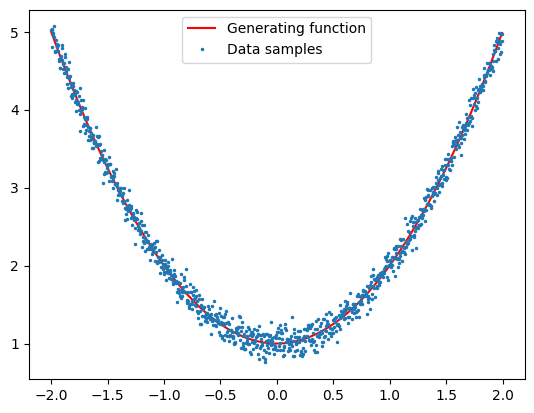

In [9]:
plt.plot(fx[:, 0], fx[:, 1], 'r')
plt.plot(data[:, 0], data[:, 1], 'o', markersize = 1.5)
plt.legend(["Generating function", "Data samples"])
plt.show()

Let us consider only the data samples and fit the data set to the following function:

$$y = f(x, \theta) = \theta_1 x^2 + \theta_0.$$

In other words, the task is to estimate $\theta = [\theta_1, \theta_2]$ that fits the function $f(x)$ with minimum *least square error*.

The least square error can be defined as:

$$l(\theta) = \sum_{i=1}^t (y_i - f(x_i, \theta))^2.$$

The least square error $l(\theta)$ is considered as the loss function that needs to be minimized with $\theta$ as the decision variables to fit the data set to $f(x, \theta)$.

The following code snippets define and visualize the least square error loss function

In [10]:
''' 
Loss function based on least squares:
Inputs
  - data: numpy array [x1i, x2i, ..., xni, yi]
  - f: function to which the data needs to be fit
  - theta: parameters in the function f
Output
  - Value of the loss function
 '''
def least_squares_loss_function(data, f, theta):
    sum = 0
    if len(data[0]) == 2:
      for i in range(0, len(data)):
          sum = sum + (data[i, -1] - f(theta, data[i, 0]))**2
    else:
      for i in range(0, len(data)):
          sum = sum + (data[i, -1] - f(theta, data[i, 0:-2]))**2
        
    return sum

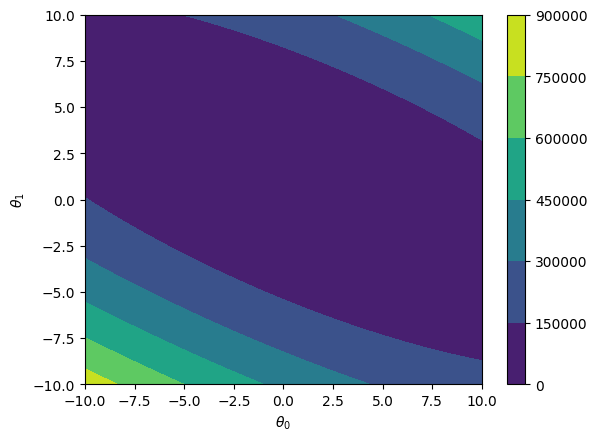

In [11]:
# Loss function with theta = [theta1, theta2] as input
def LFx(theta): 
  return least_squares_loss_function(data, f, theta)

# Plot of the loss function
lfp = contour_plot(LFx, -10., 10., 50, -10., 10., 50)
plt.colorbar(lfp)
plt.xlabel("$\\theta_0$")
plt.ylabel("$\\theta_1$")
plt.show()

In the subsequent sections, the above optimization problem is solved using SGD with different tuning parameters. 

## SGD where data is sampled with and without replacement

In this section, the regression problem is solved using SGD where the batch data is sampled with and without replacement.

Sampling batch data from the data set with replacement:

In [12]:
[soln_with_replacement, stats_with_replacement] = SGD(data, f, [0, -5], least_squares_loss_function, grad_approx, alpha = 0.02, max_iter = 5000, batch_size=10, batch_pick = "with_replacement", statistics=True)

Streaming output truncated to the last 5000 lines.
2  	 2.1033e+02 	1.6587e+02 	3.3174e+00
3  	 1.6223e+02 	1.8042e+02 	3.6084e+00
4  	 2.8752e+02 	1.0511e+02 	2.1023e+00
5  	 8.0474e+01 	7.2698e+01 	1.4540e+00
6  	 7.4219e+01 	2.5122e+01 	5.0244e-01
7  	 2.7698e+01 	1.8083e+01 	3.6165e-01
8  	 1.5609e+01 	1.4789e+01 	2.9577e-01
9  	 1.0029e+01 	2.1300e+01 	4.2599e-01
10  	 6.9755e+00 	2.2671e+01 	4.5341e-01
11  	 9.1030e+00 	1.7165e+01 	3.4331e-01
12  	 4.3435e+00 	1.6010e+01 	3.2020e-01
13  	 2.6417e+00 	1.1387e+01 	2.2774e-01
14  	 2.0097e+00 	6.0603e+00 	1.2121e-01
15  	 1.4271e+00 	2.7367e+00 	5.4733e-02
16  	 6.2150e-01 	4.2816e+00 	8.5631e-02
17  	 1.1363e+00 	4.0342e+00 	8.0684e-02
18  	 5.3517e-01 	3.2163e+00 	6.4326e-02
19  	 5.4118e-01 	2.1502e+00 	4.3003e-02
20  	 3.4782e-01 	6.5243e+00 	1.3049e-01
21  	 4.2888e-01 	5.8429e+00 	1.1686e-01
22  	 4.0958e-01 	2.9281e+00 	5.8561e-02
23  	 2.1576e-01 	2.4659e+00 	4.9317e-02
24  	 1.8109e-01 	3.7981e+00 	7.5961e-02
25  	 1.9146e-

The values for $\theta_0$ and $\theta_1$ at each iteration are plotted below along with the contour plot of the least square function. In the plot it can be seen that there is no definite pattern in how the values of $\theta_0$ and $\theta_1$ are changing. In fact, this chaoticity increases as batch size is reduced since the gradient approximation gets less accurate and more noisy.

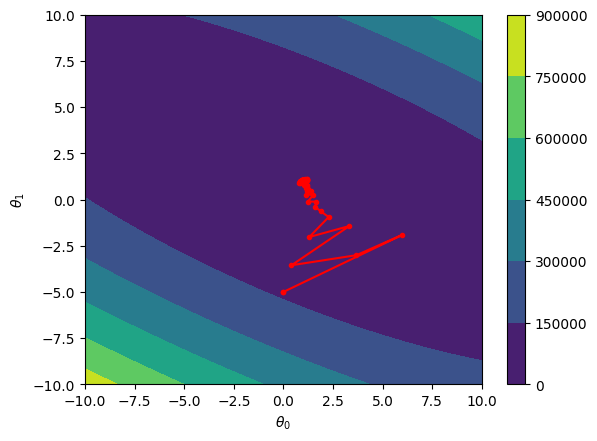

In [13]:
plt.plot(soln_with_replacement[:, 0], soln_with_replacement[:, 1], '-ro', markersize=3)
lfp = contour_plot(LFx, -10., 10., 50, -10., 10., 50)
plt.colorbar(lfp)
plt.xlabel("$\\theta_0$")
plt.ylabel("$\\theta_1$")
plt.show()

Sampling batch data from the data set without replacement:

In [14]:
[soln_without_replacement, stats_without_replacement] = SGD(data, f, [0, -5], least_squares_loss_function, grad_approx, alpha = 0.02, max_iter = 5000, batch_size=10, nepoch=50, batch_pick = "without_replacement", statistics=True)

Streaming output truncated to the last 5000 lines.
1 	 3 	 4.6114e+02 	1.5240e+02 	3.0481e+00
1 	 4 	 2.2259e+02 	3.9000e+01 	7.7999e-01
1 	 5 	 4.3656e+01 	4.5744e+01 	9.1488e-01
1 	 6 	 3.1181e+01 	6.1447e+01 	1.2289e+00
1 	 7 	 2.8195e+01 	4.1586e+01 	8.3171e-01
1 	 8 	 2.6659e+01 	1.7235e+01 	3.4469e-01
1 	 9 	 9.6852e+00 	2.6097e+01 	5.2194e-01
1 	 10 	 6.0034e+00 	3.2111e+01 	6.4222e-01
1 	 11 	 1.0159e+01 	2.0496e+01 	4.0992e-01
1 	 12 	 4.5199e+00 	1.6616e+01 	3.3231e-01
1 	 13 	 4.9112e+00 	4.8967e+00 	9.7933e-02
1 	 14 	 1.5417e+00 	7.6161e+00 	1.5232e-01
1 	 15 	 1.5394e+00 	6.0529e+00 	1.2106e-01
1 	 16 	 1.1953e+00 	4.2383e+00 	8.4765e-02
1 	 17 	 6.2241e-01 	6.1444e+00 	1.2289e-01
1 	 18 	 1.0370e+00 	3.3054e+00 	6.6107e-02
1 	 19 	 8.4851e-01 	3.6384e+00 	7.2767e-02
1 	 20 	 5.3458e-01 	1.7660e+00 	3.5320e-02
1 	 21 	 3.2346e-01 	3.7859e+00 	7.5717e-02
1 	 22 	 3.9395e-01 	3.7365e+00 	7.4729e-02
1 	 23 	 2.6784e-01 	2.7614e+00 	5.5229e-02
1 	 24 	 2.7422e-01 	3.2962e+00 

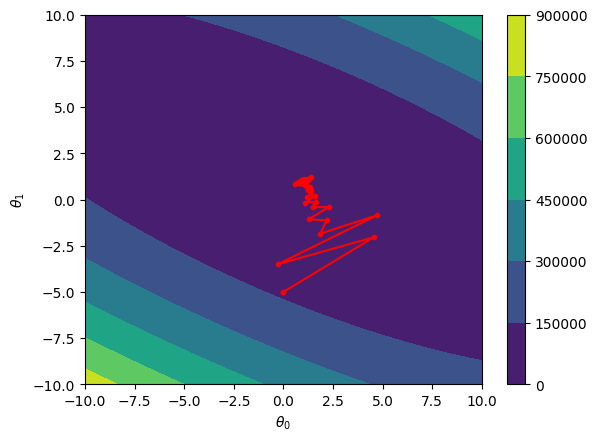

In [15]:
plt.plot(soln_without_replacement[:, 0], soln_without_replacement[:, 1], '-ro', markersize=3)
contour_plot(LFx, -10., 10., 50, -10., 10., 50)
plt.colorbar(lfp)
plt.xlabel("$\\theta_0$")
plt.ylabel("$\\theta_1$")
plt.show()

The above two data sampling methods are compared w.r.t. the number of times each data was selected during the whole run of the SGD algorithm.

From the plot below, it can be seen that sampling data without replacement results in uniform sampling of data, i.e., all the data points have equal probability of being chosen at any iteration of the SGD algorithm. This uniform sampling is ensured because the technique of shuffling the data set and selecting batches without replacement ensures the whole data set is covered in each epoch. On the other hand, for the sampling method with replacement, a random generator is used to select batches of data which will only be uniform if the number of iterations are high due to the "pseudo" randomness of the generator. Hence, in the plot below, one can see a lot of variation in the number of times each data point is sampled.

From the above discussion, data sampling without replacement is the best sampling technique since it ensures uniform sampling even at lower number of iterations. Another added benifit of using this sampling method is that it saves a lot of dynamic memory and reduces the computation complexity. These two methods have also been studied in literature, for example, [7].

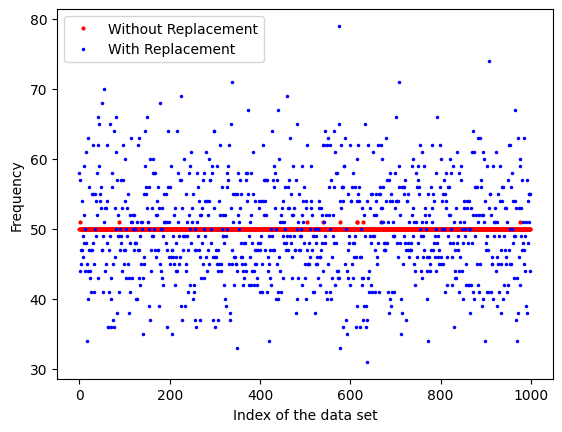

In [16]:
plt.plot(stats_without_replacement, 'ro', markersize=2)
plt.plot(stats_with_replacement, 'bo', markersize=1.5)
plt.legend(["Without Replacement", "With Replacement"])
plt.xlabel("Index of the data set")
plt.ylabel("Frequency")
plt.show()

## Study of parameters of SGD

In this section, the performance of the SGD is studied by varying the learning rate and batch size. The performance is measured using two metrics: 1) number of iterations. 2) computation time.

To find the number iterations to reach the local minimum, a box of confusion is defined which is a region around the local minimum. The value of the decision variables are said to have reached the local minimum if they are inside the box of confusion.

In [17]:
'''
Function to find the number of iterations within which the value of the decision variables
have reached inside the box of confusion
  Inputs:
  - res: Result or output from SGD function
  - box_of_confusion: numpy array - [[theta0_min, theta0_max], [theta1_min, theta1_max]]

  Output:
    - The number of iterations to get inside the box of confusion
'''
def find_iterations(res, box_of_confusion):
  for i in range(0, len(res)):
    if (res[i, 0] >= box_of_confusion[0, 0]) and (res[i, 0] <= box_of_confusion[0, 1]) and (res[i, 1] >= box_of_confusion[1, 0]) and (res[i, 1] <= box_of_confusion[1, 1]):
      return i

  return len(res)

The regression problem is solved using SGD with different batch sizes and learning rates below:

In [21]:
# Stochastic gradient descent algorithm
alpha_vals = np.linspace(0.00002, 0.0002, 10) # Range of variation of learning rate
batch_sizes = [10, 100, 500, 1000] # Batch sizes
nepochs = [1000, 1000, 1000, 1000, 1] # Number of epochs corresponding to each batch size
res_alpha_sgd = []
res_temp = []
box_of_conf = np.array([[0.97, 1.03], [0.97, 1.03]])
alpha_iter_sgd = np.zeros([len(batch_sizes), len(alpha_vals), 2])
time_taken = np.zeros([len(batch_sizes), len(alpha_vals)])
for j in range(0, len(batch_sizes)):
  for i in range(0, len(alpha_vals)):
    start_time = time.time()
    res = SGD(data, f, [0, -5], least_squares_loss_function, grad_approx, alpha = alpha_vals[i], max_iter = 350, nepoch=nepochs[j], eps1=1e-8, batch_size=batch_sizes[j], verbose=False, box_of_confusion=box_of_conf)
    end_time = time.time()
    res_temp.append(res)
    # Store the number of iterations and result from SGD
    alpha_iter_sgd[j, i, 0] = find_iterations(res, box_of_conf)
    alpha_iter_sgd[j, i, 1] = alpha_vals[i]
    # Store the computation time
    time_taken[j, i] = end_time - start_time
    print("Batch Size: {}, Learning rate: {:.2e}\n".format(batch_sizes[j], alpha_vals[i]))
  res_alpha_sgd.append(res_temp)
  res_temp = []

sol_alpha_sgd = np.array(res_alpha_sgd)

Got inside the box of confusion
Batch Size: 10, Learning rate: 2.00e-05

Got inside the box of confusion
Batch Size: 10, Learning rate: 4.00e-05

Got inside the box of confusion
Batch Size: 10, Learning rate: 6.00e-05

Got inside the box of confusion
Batch Size: 10, Learning rate: 8.00e-05

Got inside the box of confusion
Batch Size: 10, Learning rate: 1.00e-04

Got inside the box of confusion
Batch Size: 10, Learning rate: 1.20e-04

Got inside the box of confusion
Batch Size: 10, Learning rate: 1.40e-04

Got inside the box of confusion
Batch Size: 10, Learning rate: 1.60e-04

Got inside the box of confusion
Batch Size: 10, Learning rate: 1.80e-04

Got inside the box of confusion
Batch Size: 10, Learning rate: 2.00e-04

Got inside the box of confusion
Batch Size: 100, Learning rate: 2.00e-05

Got inside the box of confusion
Batch Size: 100, Learning rate: 4.00e-05

Got inside the box of confusion
Batch Size: 100, Learning rate: 6.00e-05

Got inside the box of confusion
Batch Size: 100,

<ipython-input-21-e5745aaedc3a>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sol_alpha_sgd = np.array(res_alpha_sgd)


The evolution of the value of the decision variables with iterations are visualized below:

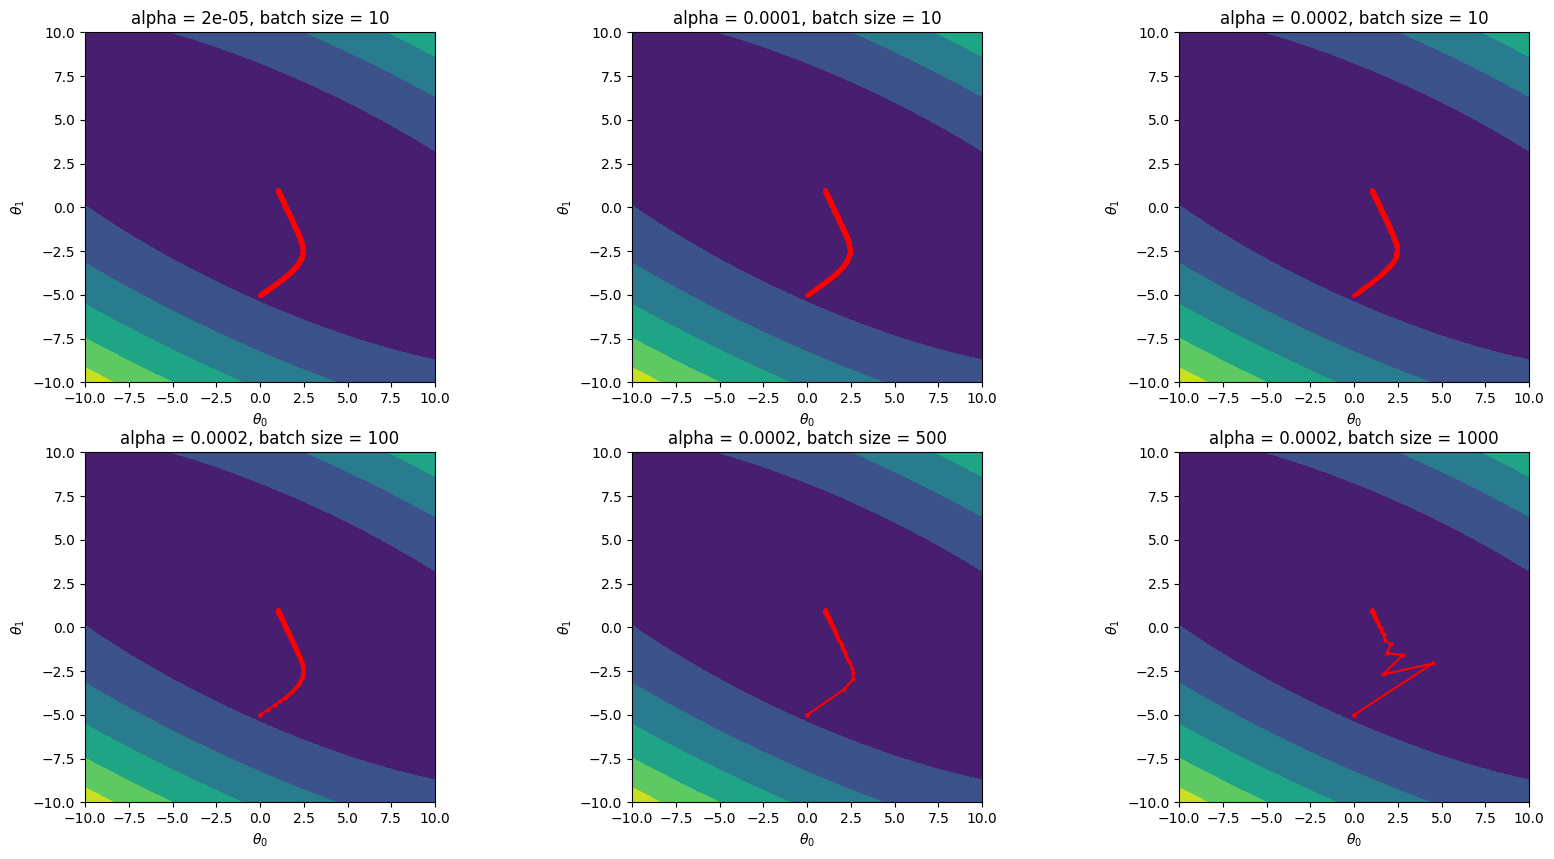

In [23]:
batch_index = [0, 0, 0, 1, 2, 3]
alpha_index = [0, 4, 9, 9, 9, 9]
fig, (ax1, ax2) = plt.subplots(2, 3)

for i in range(0, 3):
  ax1[i].plot(sol_alpha_sgd[batch_index[i], alpha_index[i]][:, 0], sol_alpha_sgd[batch_index[i], alpha_index[i]][:, 1], '-ro', markersize=2)
  ax1[i].set_title("alpha = "+str(alpha_vals[alpha_index[i]])+", batch size = "+str(batch_sizes[batch_index[i]]))
  contour_plot(LFx, -10., 10., 50, -10., 10., 50, obj=ax1[i])
  ax1[i].set_aspect(1)
  ax1[i].set_xlabel("$\\theta_0$")
  ax1[i].set_ylabel("$\\theta_1$")
  ax2[i].plot(sol_alpha_sgd[batch_index[i+3], alpha_index[i+3]][:, 0], sol_alpha_sgd[batch_index[i+3], alpha_index[i+3]][:, 1], '-ro', markersize=2)
  ax2[i].set_title("alpha = "+str(alpha_vals[alpha_index[i+3]])+", batch size = "+str(batch_sizes[batch_index[i+3]]))
  contour_plot(LFx, -10., 10., 50, -10., 10., 50, obj=ax2[i])
  ax2[i].set_aspect(1)
  ax2[i].set_xlabel("$\\theta_0$")
  ax2[i].set_ylabel("$\\theta_1$")
fig.set_figheight(10)
fig.set_figwidth(20)

From the above plots, the following can be observed:\
1) As learning rate, alpha, is increased, the step size increases.\
2) As the batch size is increased, SGD results get closer to GD results. In fact, the last plot for alpha = 0.0002 and batch size = 1000 is GD.\
3) The path followed by the parameters to minimum gets less chaotic as batch size is increased.

The number of iterations taken to get inside the box of confusion is plotted against the learning rate for different batch sizes:

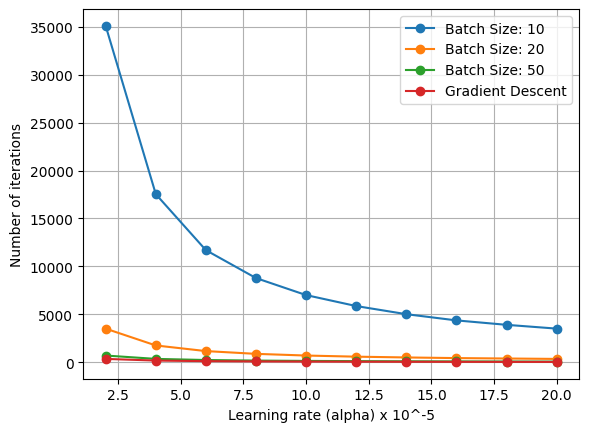

In [ ]:
for i in range(0, len(alpha_iter_sgd)):
  plt.plot(alpha_iter_sgd[i, :, 1]*(10**5), alpha_iter_sgd[i, :, 0], '-o')
plt.xlabel("Learning rate (alpha) x 10^-5")
plt.ylabel("Number of iterations")
plt.grid()
plt.legend(["Batch Size: 10", "Batch Size: 20", "Batch Size: 50", "Gradient Descent"])
plt.show()

In the above graph, it can be seen that it takes fewer iterations to get inside the box of confusion as the learning rate is increased. This is expected since increasing the learning rate results in larger steps being taken at each iteration. However, increasing the learning rate beyond 0.0002 resulted in the algorithm diverging. Furthermore, the number of iterations decreases with increase in batch size since the gradient estimated by SGD at each iteration gets nearer to the actual gradient as the batch_size is increased.

The total computation time to converge to minimum (inside the box of confusion) is plotted against batch size for different learning rates.

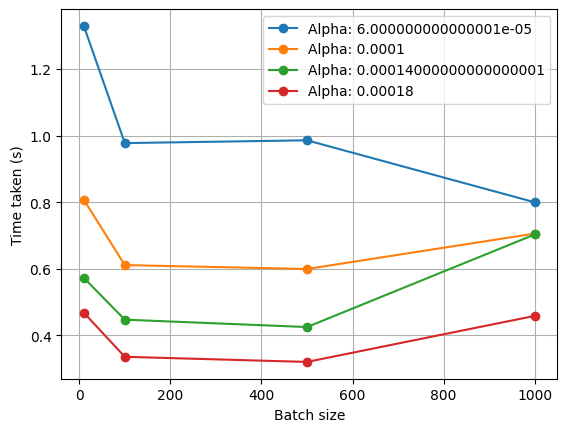

In [ ]:
lgs = []
for i in range(2, len(alpha_vals), 2):
  plt.plot(batch_sizes, time_taken[:, i], '-o')
  lgs.append("Alpha: "+str(alpha_vals[i]))

plt.xlabel("Batch size")
plt.ylabel("Time taken (s)")
plt.grid()
plt.legend(lgs)
plt.show()

From the above graph, it is evident that batch sizes between 100 and 500 have the least computation cost. For lower batch sizes, the number of iterations to converge is high which increases computation time. On the other hand, for high batch sizes, the computation time to evaluate the gradient is high.

The computation time per iteration is plotted with batch size for different learning rates.

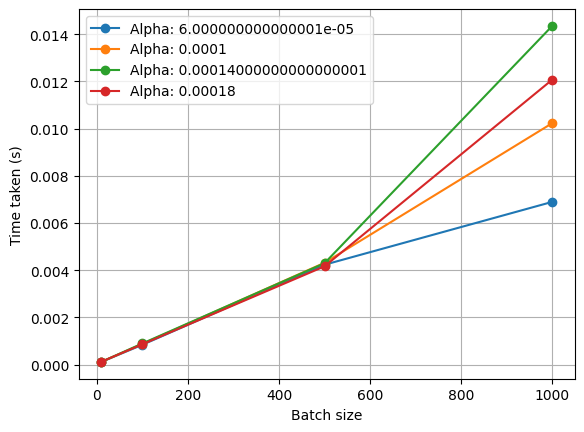

In [ ]:
lgs = []
for i in range(2, len(alpha_vals), 2):
  time_per_iter = []
  for j in range(0, len(batch_sizes)):
    time_per_iter.append(time_taken[j, i]/alpha_iter_sgd[j, i, 0])
  
  plt.plot(batch_sizes, time_per_iter, '-o')
  lgs.append("Alpha: "+str(alpha_vals[i]))

plt.xlabel("Batch size")
plt.ylabel("Time taken (s)")
plt.grid()
plt.legend(lgs)
plt.show()

From the above graph, it can be seen that the computation time per iteration reduces as the batch size is reduced. This is because lesser data samples are considered for evaluating the gradient which reduces the computational complexity and therefore, the computation time.

The next section provides an example on binary classification using logistic regression

# Binary Classification: Logistic Regression Example

Consider the height data of human males and females. From a survey, it was found that the mean height of male and female is $175$ cm and $162$ cm, respectively. The standard deviation in the height of male and female is assumed to be $3.5$ cm and $4$ cm, respectively. The following code snippet generates height data of males and females by sampling from a gaussian distribution with the aforemnetioned mean and standard deviation information.

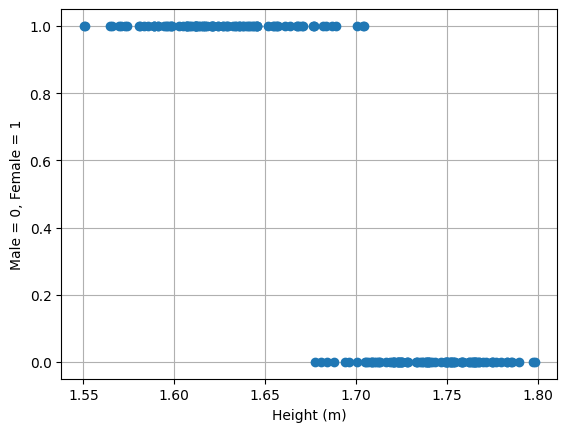

In [ ]:
## Generation of data-set
# Parameters
n = 100 # No. of males (or females). Total number of humans is 2*n
mu1 = 1.75 # Mean of male heights
sigma1 = 0.035 # Standard deviation of male heights
mu2 = 1.62 # Mean of female heights
sigma2 = 0.035 # Standard deviation of female heights
xRange = [1.55, 1.8] # Range of heights considered

data = np.zeros([2*n, 2])
i=0
flag1 = False
flag2 = False
while i < 2*n:
  
  # Male height data set are labelled 0
  rand = np.random.normal(mu1, sigma1)
  if rand <= xRange[1] and rand >= xRange[0]:
    data[i, 0] = rand
    flag1 = True

  # Female height data set are labelled 1
  rand = np.random.normal(mu2, sigma2)
  if rand <= xRange[1] and rand >= xRange[0]:
    data[i+1, 0] = rand
    data[i+1, 1] = 1
    flag2 = True

  if flag1 and flag2:
    i = i+2
    flag1 = False
    flag2 = False

plt.plot(data[:, 0], data[:, 1], 'o')
plt.xlabel("Height (m)")
plt.ylabel("Male = 0, Female = 1")
plt.grid()
plt.show()

The goal is to come up with a model that classifies the given height data into male and female classes. Firstly, the function that defines the model is assumed and the above generated data is used to tune the parameters of the function such that it best fits the data.\
The function assumed to model the data is a logistic function defined as:

\begin{align}
&y = \textrm{sig}(z), \quad \textrm{where,} \\
&z = \theta_0 x + \theta_1, \\
&\textrm{sig}(z) = \frac{1}{1+e^{-z}}.
\end{align}

In the above equation, $x$ is the height and $y$ is the probability of a given height data belonging to the female class. Further, $\textrm{sig}(z)$ is known as the sigmoid function and $\theta_0, \theta_1$ are the tuning parameters of the logistic function. For a given height data, if the output $y$ computed from the above equation is more than $0.5$, then the data is classified as female. Otherwise, the data is classified as male.\
The following code snippets define and plot the logistic function

In [ ]:
''' 
Sigmoid function
Input 
  - x: input value
Output 
  - result of the sigmoid function
 '''
def sigmoid(x):
  return 1/(1+np.exp(-x))

In [ ]:
'''
Logistic function
Input
  - x: height 
  - theta: [theta_0, theta_1] tuning parameters
Output
  - probability of the height data belonging to the female class
'''
def logistic_function(x, theta):
  return sigmoid(theta[1]*x + theta[0])

In [ ]:
'''
Function for plotting the logistic function
Inputs
  - theta: [theta0, theta1] parameters of the logistic function
  - data: [[x1, y1], [x2, y2], ..., [xn, yn]] labelled height data where
          xi - height
          yi - label (Male -> 0 and Female -> 1)
  - xRange: Range of height over which the logistic function is plotted
  - N: number of points to be sampled from the logistic function for plotting
'''
def plot_logistic_function(theta, data, xRange, N=100):
  x = np.linspace(xRange[0], xRange[1], N)
  fval = []
  for i in range(0, len(x)):
    fval.append(logistic_function(x[i], theta))

  plt.plot(x, fval)
  plt.plot(data[:, 0], data[:, 1], 'o')
  plt.xlabel("Height (m)")
  plt.ylabel("Male = 0, Female = 1")
  plt.legend(["Model", "Given Data"])
  plt.grid()
  plt.show()

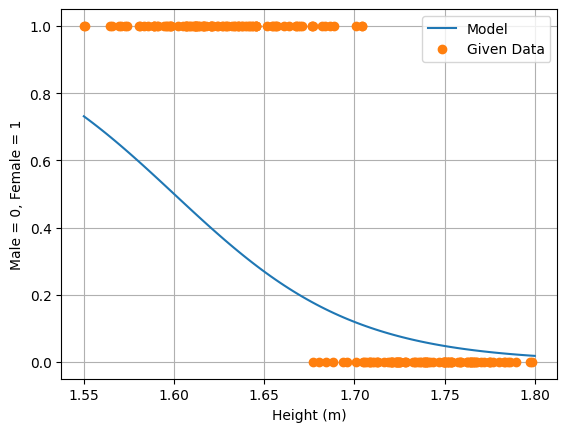

In [ ]:
plot_logistic_function([32, -20], data, xRange)

Having defined the logistic function, the parameters of it must be tuned to best fit the given height data. For this problem, the least square objective function cannot be used to optimize for the parameters due to the following reasons:

1) The output of the logistic function varies continously from 0 to 1 while the given height data have discrete values for their label, i.e., 0 or 1.

2) The least square metric does not make sense since the output of the logistic function is the probability of a given data point belonging to the female class. Instead it makes more sense to maximize the likelihood of the model correctly classifying the data.

Therefore, the loss function for this problem is defined in terms of the likelihood of the model, defined by the logistic function, predicting the class of a given data point correctly. Let $p_k$ be the probability of the $k$th data point, namely $x_k$, belonging to the female class. Since only two classes are involved, the probability of $x_k$ belonging to the male class is $1-p_k$. Further, let $y_k$ denote the value of the label given to each data set, i.e., either $0$ or $1$. The likelihood of the model predicting the $k$th data point correctly is given by:

\begin{align}
&l_k = p_k^{y_k}(1-p_k)^{1-y_k}, \quad \textrm{where,}\\
&p_k = \textrm{sig}(\theta_0 x + \theta_1).
\end{align}

If the given data point, $x_k$, belongs to the female class, i.e., $y_k = 1$ and the model prediction is correct, i.e., $p_k \rightarrow 1$, then $l_k = 1$. Similarly, if $x_k$ belongs to the male class and the model prediction is correct, i.e., $p_k \rightarrow 0$, then $l_k = 1$. Thus, $l_k = 1$ if the model predicts prefectly correctly, $l_k = 0$ if the model prediction is perfectly incorrect and anything in between otherwise.\
The likelihood of the model classifying all the data points $x_k, k=1,2,..,n,$ correctly is:

\begin{align}
l = \prod_{k=1}^{n} l_k = \prod_{k=1}^{n} p_k^{y_k}(1-p_k)^{1-y_k}.
\end{align}

For the model to best fit the given data, the goal is to maximize the likelihood of the model classifying the data correctly as given by the above equation. To solve this optimization problem using SGD, $l$ needs to be cast as the sum of functions instead of product of functions as in the above equation. For this, logarithmic function of $l$ is considered:

\begin{align}
l_l = \log (l) = \sum_{k=1}^{n} (y_k \log(p_k) + (1-y_k) \log(1-p_k)).
\end{align}

From the above equation, maximizing $l_l$ leads to maximization of $l$ (since the log function is monotonic with $\log(0) = -\infty$ and $\log(1) = 0$). To pose the problem as a minimization problem, the negative of $l_l$ is considered as the objective function:

\begin{align}
l_s = -l_l = \sum_{k=1}^{n} (-y_k \log(p_k) - (1-y_k) \log(1-p_k)).
\end{align}

The above objective function is commonly known as the logistic loss function or maximum likelihood function and is minimised using SGD. The following code snippets define and minimize the logistic loss function.

In [ ]:
'''
Logistic loss function
Inputs:
  - data: [[x1, y1], [x2, y2], ..., [xn, yn]] labelled height data where
          xi - height
          yi - label (Male -> 0 and Female -> 1)
  - logistic_function: the logistic function defined previously
  - theta: [theta0, theta1] parameters of the logistic function
'''
def logistic_loss_function(data, logistic_function, theta):
  sum = 0
  for i in range(0, len(data)):
    fval = logistic_function(data[i, 0], theta)
    sum = sum - (data[i, 1])*np.log(fval) - (1-data[i, 1])*np.log(1-fval)

  return sum

In [ ]:
# Testing of the logistic loss function
logistic_loss_function(data, logistic_function, [32, -20])

109.50068183030183

In [ ]:
# Minimization of the logistic loss function using SGD
sol_lr = SGD(data, logistic_function, [32, -20], logistic_loss_function, grad_approx, alpha = 0.5, max_iter = 1000, batch_size=10, nepoch=120, batch_pick="without_replacement")

Epoch 	Iter. 	loss_func(x) 		||grad(x)|| 	||p||

1 	 0 	 4.2544e+00 	3.0913e+00 	1.5457e+00
1 	 1 	 4.2544e+00 	4.9534e+00 	2.4767e+00
1 	 2 	 5.8958e+00 	8.1846e+00 	4.0923e+00
1 	 3 	 1.0466e+01 	1.8601e+00 	9.3005e-01
1 	 4 	 4.2012e+00 	1.3379e+01 	6.6896e+00
1 	 5 	 1.5415e+01 	9.5254e+00 	4.7627e+00
1 	 6 	 4.4626e+01 	4.1372e+00 	2.0686e+00
1 	 7 	 5.1246e+00 	1.3949e+01 	6.9744e+00
1 	 8 	 1.6834e+01 	1.1398e+01 	5.6992e+00
1 	 9 	 5.4230e+01 	3.2309e+00 	1.6155e+00
1 	 10 	 3.3191e+00 	8.8285e+00 	4.4142e+00
1 	 11 	 1.0063e+01 	8.0099e+00 	4.0050e+00
1 	 12 	 1.8431e+01 	5.2977e+00 	2.6488e+00
1 	 13 	 5.9064e+00 	7.0159e+00 	3.5080e+00
1 	 14 	 9.6301e+00 	8.1830e+00 	4.0915e+00
1 	 15 	 1.1362e+01 	7.7124e+00 	3.8562e+00
1 	 16 	 1.4821e+01 	8.2493e+00 	4.1246e+00
1 	 17 	 1.0871e+01 	7.8282e+00 	3.9141e+00
1 	 18 	 1.4307e+01 	5.3425e+00 	2.6713e+00
1 	 19 	 6.1608e+00 	7.9610e+00 	3.9805e+00
2 	 20 	 8.7113e+00 	1.0984e+01 	5.4919e+00
2 	 21 	 2.2047e+01 	1.1896e+01 	5.94

In [ ]:
# Parameter values after optimization
print("theta0 = "+str(sol_lr[-1, 0])+", theta1 = "+str(sol_lr[-1, 1]))

theta0 = 86.40420776464673, theta1 = -51.43953145878783


The values for $\theta_0, \theta_1$ at each iteration are plotted along with the contour plot of the logistic loss function. From the below graph, it can be seen that the loss function is reducing with the number of iterations.

<ipython-input-31-fa65fd521ce4>:14: RuntimeWarning: divide by zero encountered in log
  sum = sum - (data[i, 1])*np.log(fval) - (1-data[i, 1])*np.log(1-fval)
<ipython-input-31-fa65fd521ce4>:14: RuntimeWarning: invalid value encountered in double_scalars
  sum = sum - (data[i, 1])*np.log(fval) - (1-data[i, 1])*np.log(1-fval)


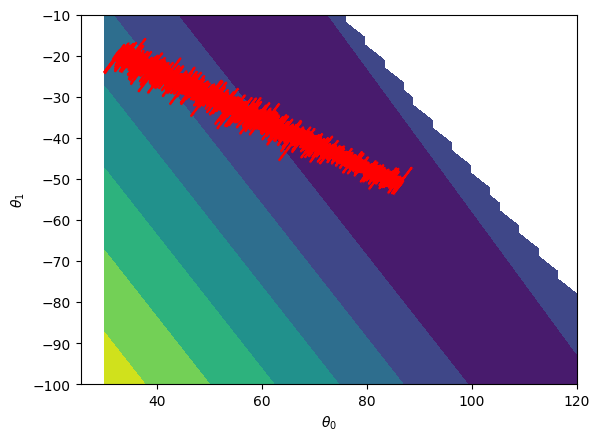

In [ ]:
LR = lambda theta : logistic_loss_function(data, logistic_function, theta)
plt.plot(sol_lr[:, 0], sol_lr[:, 1], '-ro', markersize=0.1)
contour_plot(LR, 30, 120, 50, -100., -10., 50)
plt.xlabel('$\\theta_0$')
plt.ylabel('$\\theta_1$')
plt.show()

The model with the optimised tuning parameters is compared against the given data.

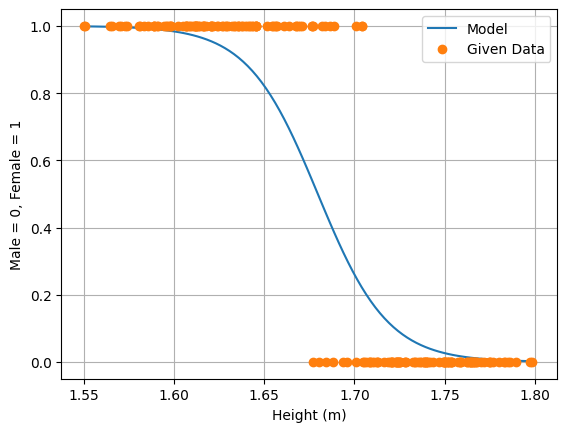

In [ ]:
plot_logistic_function(sol_lr[-1, 0:2], data, xRange)

The success rate of the model predicting the given data point correctly is found using the following routine.

In [ ]:
def lr_success_rate(data, logistic_function, theta):
  success = 0
  for i in range(0, len(data)):
    if(abs(logistic_function(data[i, 0], theta) - data[i, 1]) < 0.5):
      success = success + 1
  
  return 100.*success/len(data)

In [ ]:
print("The success rate of the model prediction before optimization: "+str(lr_success_rate(data, logistic_function, [32, -20])))
print("The success rate of the model prediction after optimization: "+str(lr_success_rate(data, logistic_function, sol_lr[-1, 0:2])))

The success rate of the model prediction before optimization: 62.0
The success rate of the model prediction after optimization: 96.0


From the above results, it is clear that there is significant improvement in the success rate of the model predicting correctly after minimising the logistic loss function.

# Conclusions

This notebook explains the stochastic gradient descent algorithm and its applications in regression and classification problems encountered in statistics and machine learning. The algorithm was implemented in python and the performance of SGD in terms of the computation time and number of iterations was studied for different batch sizes and learning rates. The following trends were observed:

1) The number of iterations reduces with increase in batch size due to improvement in the gradient approximation.

2) The number of iterations reduces with increase in learning rate due to larger steps taken at each iteration.

3) The computation time per iteration reduces with decrease in batch size due to decrease in the number of summands in the objective function considered to approximate the gradient.

4) The total computation time was observed to be minimal when around $10$% of the data (sampled randomly) was used to approximate the gradient at each iteration. At low batch sizes, the number of iterations to converge is high and the total time increases. On the other hand, for high batch sizes, the computation time per iteration increases which increases the total computation time.

5) The total computation time also reduces with increase in alpha due to decrease in the number of iterations.

The two methods for data sampling, i.e., with and without replacement, were also compared. The method of data sampling without replacement turned out to be superior in terms of uniformly sampling all the data points and saving memory during computations. From the above results, one can conclude that SGD is superior to GD in terms of reduced computation time for large data sets.\
In this notebook, the basic SGD algorithm has been discussed with simple toy examples. Further details on modifying the algorithm by changing learning rate, decay rate, etc., at each iteration to make SGD more robust and suitable for large scale applications can be found in [4].

# References

[1] Wei Wu, Jian Wang, Mingsong Cheng, Zhengxue Li, Convergence analysis of online gradient method for BP neural networks, Neural Networks, Volume 24, Issue 1, 2011, pp. 91-98, ISSN 0893-6080, https://doi.org/10.1016/j.neunet.2010.09.007.

[2] Li-Hua Ren, Zhi-Feng Ye, Yong-Ping Zhao, A modeling method for aero-engine by combining stochastic gradient descent with support vector regression,
Aerospace Science and Technology, Volume 99, 2020, 105775, ISSN 1270-9638,
https://doi.org/10.1016/j.ast.2020.105775.

[3] Nhat-Duc Hoang, Automatic detection of asphalt pavement raveling using image texture based feature extraction and stochastic gradient descent logistic regression, Automation in Construction, Volume 105, 2019, 102843, ISSN 0926-5805, https://doi.org/10.1016/j.autcon.2019.102843.

[4] N. Ketkar, Stochastic Gradient Descent, In: Deep Learning with Python. Apress, Berkeley, CA, 2017, https://doi.org/10.1007/978-1-4842-2766-4_8.

[5] X. Su, X. Yan and C.-L. Tsai, Linear regression, WIREs Comp Stat, 4: 275-294, 2012 https://doi.org/10.1002/wics.1198.

[6] R. E. Wright, Logistic regression, In L. G. Grimm & P. R. Yarnold (Eds.), Reading and understanding multivariate statistics, American Psychological Association, 1995, pp. 217–244.

[7] Ohad Shamir, Without-Replacement Sampling for Stochastic Gradient Methods,  Advances in Neural Information Processing Systems 29, NIPS 2016.
